# Calculate Compound Years for CESM

This file grabs the warm season indeces and sees if this shows us anything


You need to run cesmIndeces.ipnyb first

In [1]:
#For plots of a single experiment to demonstrate things, plot this one:

expToPlot = 'LME.002'

In [2]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
from utils.timePeriod import averageForTimePeriod

%run "utils/compound.ipynb"

In [3]:
import xarray
import matplotlib.pyplot as plt
import numpy
import pandas

%matplotlib inline

In [4]:
# Here is the data
indecesXr = xarray.load_dataset('results/cesmTradIndeces.nc')

indecesXr.experiment.values

array(['LME.002', 'LME.003', 'LME.008', 'LME.009', '0850cntl.001', '001',
       '002', '003', '004', '005', '006', '007', '008', '009', '010',
       '011', '012', '013'], dtype=object)

Same criteria as 'cesmIndeces' file

In [5]:
# define some criteria that we want to use to identifiy it thats an event
criteriaXr= xarray.merge(
    (indecesXr[['nino34','dmi']].std(dim='year'), indecesXr['sam'].std(dim='year')/2)
)

# Plot time trends (nino is detrended)

CESM Model Run: LME.002


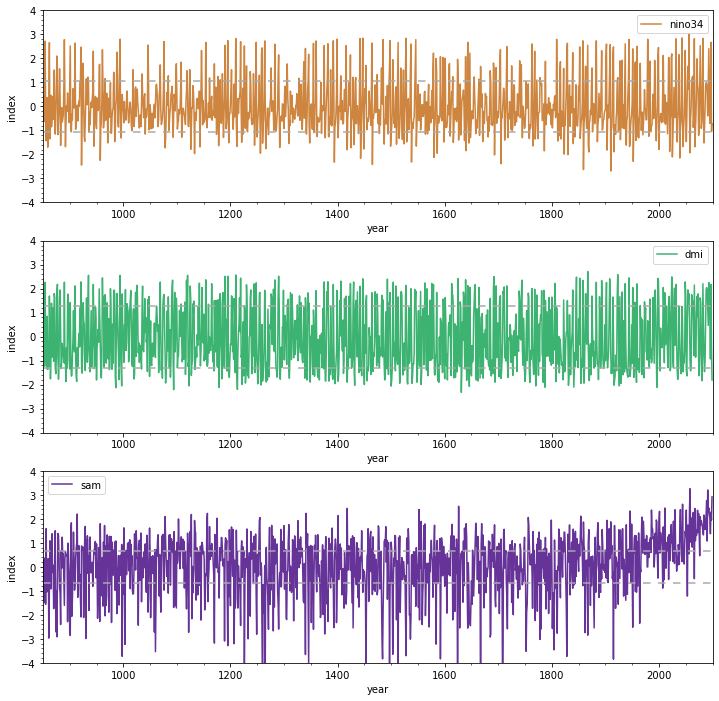

In [6]:
# plot indeces for an experiment, and add some lines for +- 1 sigma

indexToPlot = ['nino34', 'dmi', 'sam']
colors = ['peru', 'mediumseagreen', 'rebeccapurple']
lims = [(-4,4), [-4,4], [-4,4]]

print('CESM Model Run: ' + expToPlot)

# first define somewhere to plot
fig = plt.figure(figsize=(12,12))

for i in range(3):
    
    fig.add_subplot(3,1,i+1)
    
    # plot the actual data
    plotData=indecesXr[indexToPlot[i]].sel(experiment=expToPlot) 
    plt.plot(plotData.year, plotData.values, label=indexToPlot[i], color=colors[i])
    
    # draw some horizontal lines for criteria
    eventCrit=criteriaXr[indexToPlot[i]].sel(experiment=expToPlot).values
    plt.axhline(y=eventCrit, dashes=(5,5), color='darkgrey')
    plt.axhline(y=-eventCrit, dashes=(5,5), color='darkgrey')

    #Tidy up a bit
    plt.xlabel('year')
    plt.ylabel('index')
    plt.xlim(850,2100)
    plt.ylim(lims[i])
    plt.minorticks_on()
    plt.legend()


# Calculate the compounding years and plot an example

In [7]:
firePos=xarray.open_dataset('results/cesmFirePos.nc')

fireNeg=xarray.open_dataset('results/cesmFireNeg.nc')

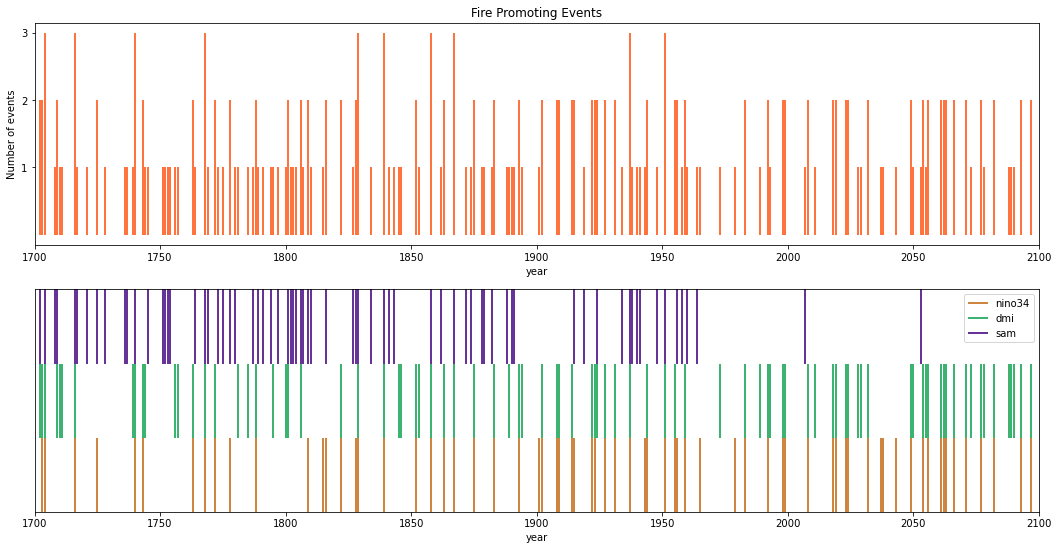

In [17]:
toPlot=(firePos.sel(experiment=expToPlot))

plt.figure(figsize=(18,9))

#plot the pos events in orange 

plt.subplot(2,1,1)

plt.vlines(
    x=toPlot.year, 
    ymin=0,
    ymax=toPlot.nEvents,
    colors='orangered', 
    label=expToPlot
)
plt.xlim(1700,2100)
plt.xlabel('year')
plt.ylabel('Number of events')
plt.yticks([1,2,3])
plt.title('Fire Promoting Events')

plt.subplot(2,1,2)
iPlot=0
for iIndex in indexToPlot:
    plt.vlines(
        x=(toPlot[iIndex].where(toPlot[iIndex])).year, 
        ymin=iPlot,
        ymax=(iPlot+1)*(toPlot[iIndex].where(toPlot[iIndex])),
        color=colors[iPlot], 
        label=iIndex,
        linewidth=2
    )
    iPlot=iPlot+1
    plt.legend()
    plt.xlim(1700,2100)
    plt.xlabel('year')
    plt.ylim([0,3])
    plt.yticks([])


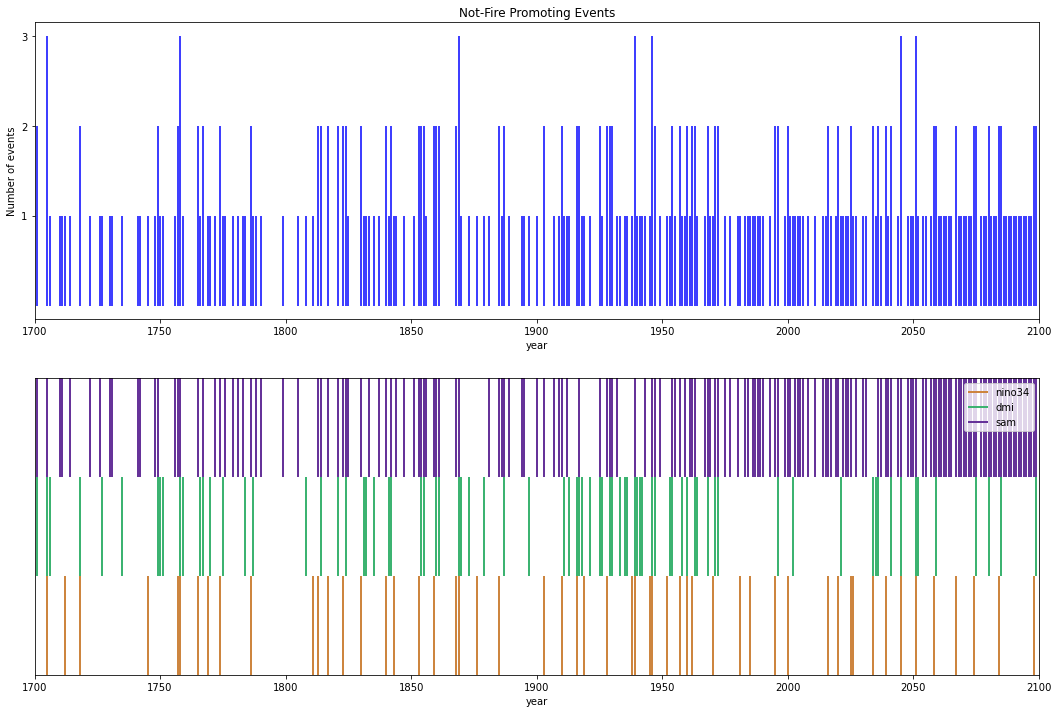

In [18]:
# and the neg count in blue

toPlot=(fireNeg.sel(experiment=expToPlot))

plt.figure(figsize=(18,12))

plt.subplot(2,1,1)
plt.vlines(
    x=toPlot.year, 
    ymin=0,
    ymax=toPlot.nEvents,
    colors='blue', 
    label=expToPlot
)
plt.xlim(1700,2100)
plt.xlabel('year')
plt.ylabel('Number of events')
plt.yticks([1,2,3])
plt.title('Not-Fire Promoting Events')


plt.subplot(2,1,2)
iPlot=0
for iIndex in indexToPlot:

    plt.vlines(
        x=(toPlot[iIndex].where(toPlot[iIndex])).year, 
        ymin=iPlot,
        ymax=(iPlot+1)*(toPlot[iIndex].where(toPlot[iIndex])),
        color=colors[iPlot], 
        label=iIndex,
        linewidth=2
    )
    iPlot=iPlot+1
    plt.legend()
    plt.xlim(1700,2100)
    plt.xlabel('year')
    plt.ylim([0,3])
    plt.yticks([])


# Put the compounds into 30 year intervals

In [10]:
yearBins=numpy.arange(860, 2100, 30)

binMid=numpy.arange(875, 2086, 30)

binnedFirePos=firePos.groupby_bins('year', yearBins, labels=binMid ).sum() 



binnedPosCount=(firePos.nEvents>1).groupby_bins('year', yearBins, labels=binMid).sum() 
binnedPosCount= binnedPosCount.rename({'year_bins':'year'})


binnedNegCount=(fireNeg.nEvents>1).groupby_bins('year', yearBins, labels=binMid).sum()
binnedNegCount= binnedNegCount.rename({'year_bins':'year'})

Plot of main ensemble runs over time

Text(0.5, 1.0, 'Events in non-overlapping 30 year bins for main ensemble runs.')

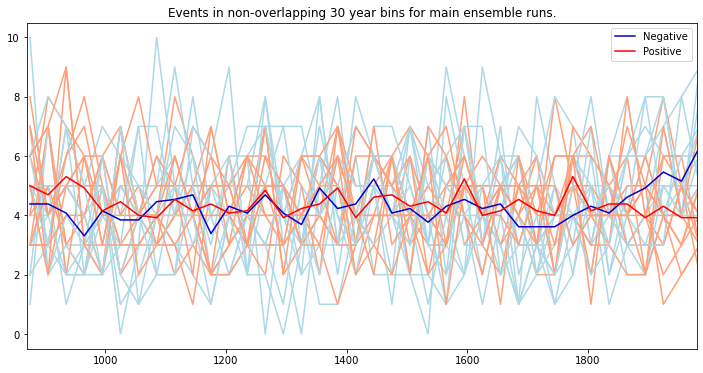

In [11]:
fig = plt.figure(figsize=(12,6))

for iExp in _model.cesmFullForcings:
    plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=iExp).values, color='lightblue')
    plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=iExp).values, color='lightsalmon')
    
plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=_model.cesmFullForcings).mean(dim='experiment') , color='mediumblue', label='Negative')
plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=_model.cesmFullForcings).mean(dim='experiment') , color='red', label = 'Positive')   

plt.xlim(870, 1980)
plt.legend()
plt.title('Events in non-overlapping 30 year bins for main ensemble runs.')

Plot of runs with RCP 8.5 forcings

Text(0.5, 1.0, 'Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')

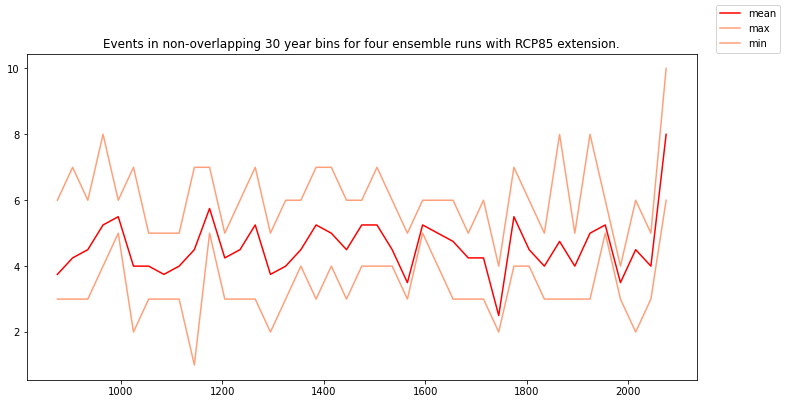

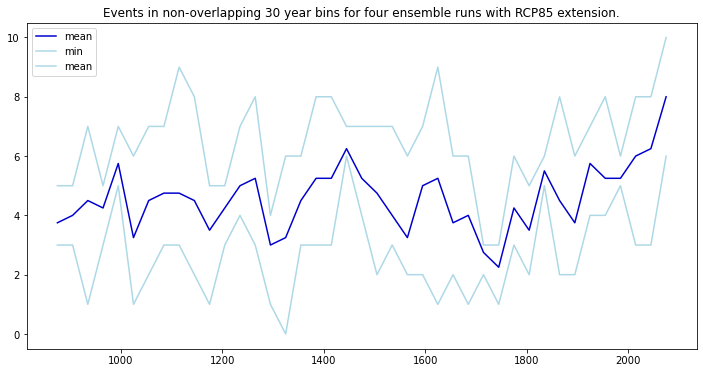

In [12]:
fig = plt.figure(figsize=(12,6))

    
plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=_model.cesmRcp85).mean(dim='experiment') , color='red', label='mean')   
plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=_model.cesmRcp85).max(dim='experiment') , color='lightsalmon', label='max')
plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=_model.cesmRcp85).min(dim='experiment') , color='lightsalmon', label='min')

fig.legend()

plt.title('Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')



fig = plt.figure(figsize=(12,6))
    
plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=_model.cesmRcp85).mean(dim='experiment') , color='mediumblue', label='mean')
plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=_model.cesmRcp85).max(dim='experiment') , color='lightblue', label='min')
plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=_model.cesmRcp85).min(dim='experiment') , color='lightblue', label='mean')

plt.legend()

plt.title('Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')

# Overlapping bins

In [13]:
overlapBinFirePos=overlappingBinSum(firePos.nEvents>1)
overlapBinFireNeg=overlappingBinSum(fireNeg.nEvents>1)


In [14]:
overlapBinFireNeg

<xarray.DataArray 'nEvents' (year: 123, experiment: 18, std: 1)>
array([[[6.],
        [5.],
        [4.],
        ...,
        [2.],
        [6.],
        [5.]],

       [[5.],
        [4.],
        [3.],
        ...,
        [2.],
        [6.],
        [4.]],

       [[4.],
        [4.],
        [1.],
        ...,
...
        ...,
        [0.],
        [0.],
        [0.]],

       [[6.],
        [7.],
        [9.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[7.],
        [9.],
        [9.],
        ...,
        [0.],
        [0.],
        [0.]]])
Coordinates:
  * experiment  (experiment) object 'LME.002' 'LME.003' ... '012' '013'
  * std         (std) object '0850cntl.001'
  * year        (year) int32 865 875 885 895 905 ... 2045 2055 2065 2075 2085
Attributes:
    Bins:     Overlapping 30 year bins, seperating by 10 year intervals
    Year:     Midpoint of bin

Text(0.5, 1.0, 'Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')

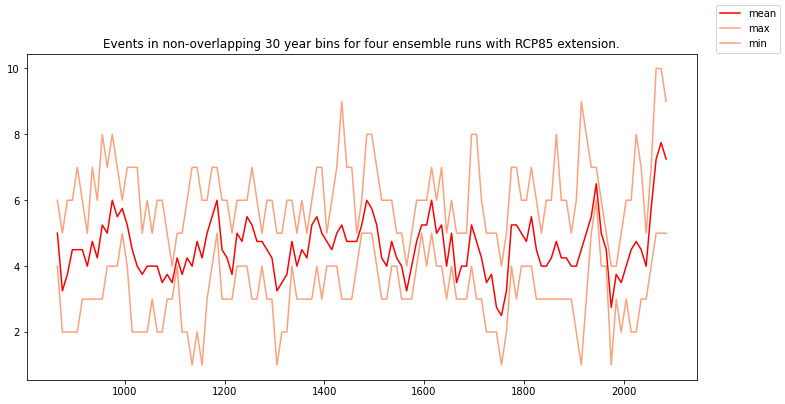

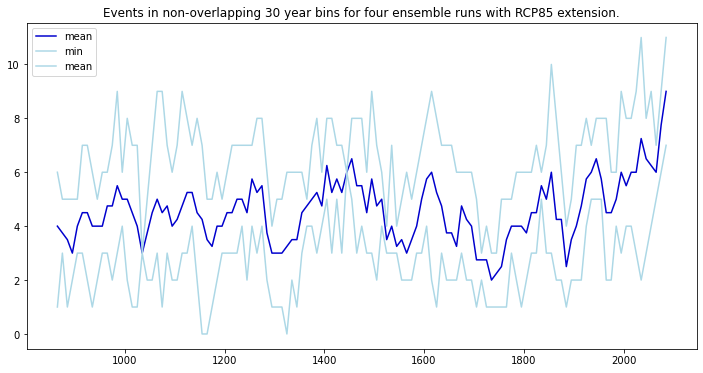

In [15]:
fig = plt.figure(figsize=(12,6))

    
plt.plot(overlapBinFirePos.year, overlapBinFirePos.sel(experiment=_model.cesmRcp85).mean(dim='experiment') , color='red', label='mean')   
plt.plot(overlapBinFirePos.year, overlapBinFirePos.sel(experiment=_model.cesmRcp85).max(dim='experiment') , color='lightsalmon', label='max')
plt.plot(overlapBinFirePos.year, overlapBinFirePos.sel(experiment=_model.cesmRcp85).min(dim='experiment') , color='lightsalmon', label='min')

fig.legend()

plt.title('Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')



fig = plt.figure(figsize=(12,6))
    
plt.plot(overlapBinFireNeg.year, overlapBinFireNeg.sel(experiment=_model.cesmRcp85).mean(dim='experiment') , color='mediumblue', label='mean')
plt.plot(overlapBinFireNeg.year, overlapBinFireNeg.sel(experiment=_model.cesmRcp85).max(dim='experiment') , color='lightblue', label='min')
plt.plot(overlapBinFireNeg.year, overlapBinFireNeg.sel(experiment=_model.cesmRcp85).min(dim='experiment') , color='lightblue', label='mean')

plt.legend()

plt.title('Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')

# Rolling 30 year intervals instead

(0.0, 8.0)

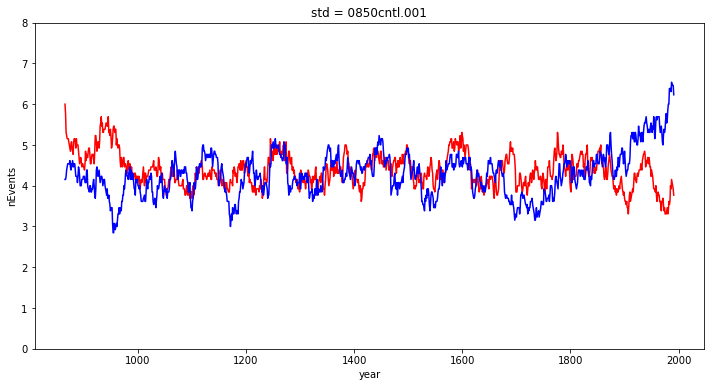

In [16]:
fig = plt.figure(figsize=(12,6))

rollingPCount=(
    firePos.nEvents.where(firePos.year<=2005, drop=True).sel(
    experiment=_model.cesmFullForcings)>1
              ).rolling(
    year=30, center=True
).sum('year').dropna('year')

rollingPCount.mean(dim='experiment').plot(label='mean', color='red')

rollingNCount=(
    fireNeg.nEvents.where(fireNeg.year<=2005, drop=True).sel(experiment=_model.cesmFullForcings)>1
).rolling(
    year=30, center=True
).sum('year').dropna('year')

rollingNCount.mean(dim='experiment').plot(label='mean', color='blue')


plt.ylim(0,8)